In [102]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import glob
import os.path as osp

In [164]:
K = 4
EPS_FACTOR = 1.3 

In [166]:
DATA_DIR = "/home/alma/w-projects/help/franzi/rsc/cluster/joint/"
RES_DIR = "/home/alma/w-projects/help/franzi/res/cluster/nbrs/"
pths = glob.glob(osp.join(DATA_DIR,"*tsv"))



In [167]:
data = list()
for pth in pths:
    _tmp = pd.read_csv(pth,sep = "\t",header = 0,index_col = 0)
    data.append(_tmp)

In [168]:
cluster_label = "cluster"

In [169]:
all_sample_stats = dict()

all_labels = list()

for _tmp in data:
    
    _drop = np.isnan(_tmp[cluster_label].values)
    _tmp = _tmp.iloc[~_drop,:]
    
    _crd = _tmp[["new_x","new_y"]].values
    _crd /= _crd.max()
    _kd = KDTree(_crd)
    
    ds,idxs = _kd.query(_crd, k =  2)
    upper_bound = ds[:,1::].mean() * EPS_FACTOR  * 0.9
    
    ds,idxs = _kd.query(_crd, k = K +1, distance_upper_bound = upper_bound)
    ds = ds[:,1::]
    idxs = idxs[:,1::]
    
    uni_labels = np.unique(_tmp[cluster_label].values)
    np.sort(uni_labels)
    
    all_labels += uni_labels.tolist()
    
    n_labels = uni_labels.shape[0]

    tmp_labels = np.append(_tmp[cluster_label].values,"none")

    for label in uni_labels:
        if label not in all_sample_stats.keys():
            all_sample_stats[label] = list()
        
        pos = np.where(_tmp[cluster_label].values == label)[0]

        nn_stats = np.zeros((pos.shape[0],
                             n_labels + 1,
                            ))

        nn_stats = pd.DataFrame(nn_stats,
                            columns = pd.Index(np.append(uni_labels,"none").astype(str)),
                           )

        for k,p in enumerate(pos):
            nbr_labels = tmp_labels[idxs[p,:]]
            val,cnt = np.unique(nbr_labels,return_counts = True)
            nn_stats.loc[k,val.astype(str)] = cnt

        all_sample_stats[label].append(nn_stats.iloc[:,nn_stats.columns != "none"])
        
for k,v in all_sample_stats.items():
    all_sample_stats[k] = pd.concat(v)

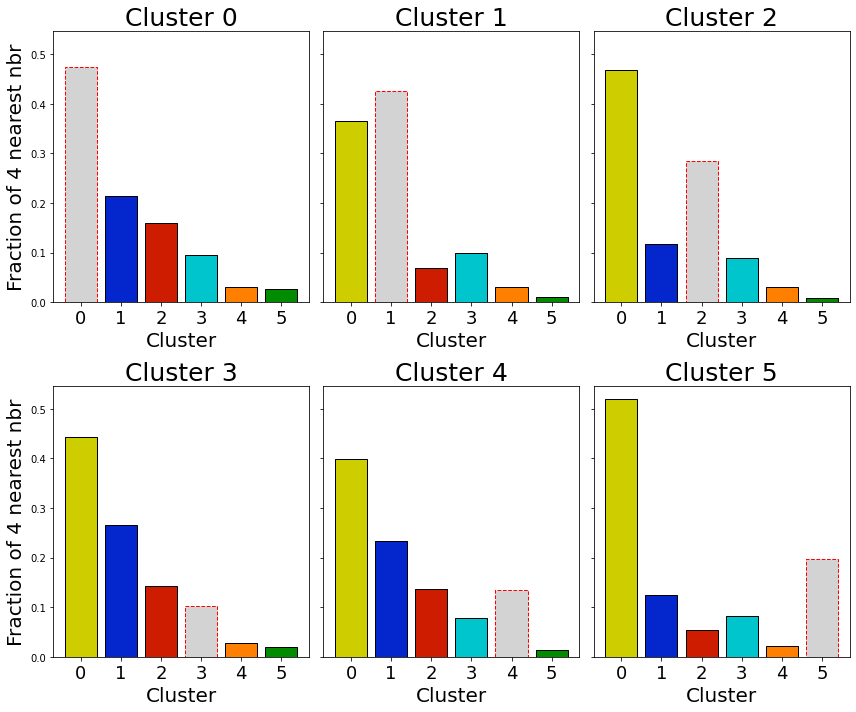

In [179]:
n_labels = len(all_sample_stats)
uni_labels = list(all_sample_stats.keys())
uni_labels.sort()

n_rows = 2
n_cols = int(np.ceil(n_labels / n_rows))

fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (n_cols * 4,
                                 n_rows * 5),
                      facecolor = "white",
                      sharey = True,
                     )

ax = ax.flatten()
#cmap = plt.cm.rainbow

cmap = {0: "#CDCD00",
        1 : "#0327CD",
        2 : "#CD1C00",
        3 : "#01C5CD",
        4 : "#FF7F00",
        5 : "#008B00",
       }

for k,label in enumerate(uni_labels):
    val = all_sample_stats[label].sum(axis=0)
    val /= val.sum()
    xs = np.arange(n_labels)
    bar = ax[k].bar(xs,val,edgecolor = "black",facecolor ="lightgray")
    
    for n,(p,l) in enumerate(zip(bar.patches,uni_labels)):
        if l != label:
            if l in cmap.keys():
                p.set_facecolor(cmap[l])
            else:
                p.set_facecolor(plt.cm.rainbow(n / n_labels))
        else:
            p.set_edgecolor("red")
            p.set_linestyle("dashed")
    
    ax[k].set_xticks(xs)
    ax[k].set_xticklabels(["{}".format(x) for x in uni_labels],
                          rotation = 0,
                          fontsize = 18)
    ax[k].set_title("Cluster {}".format(label),fontsize = 25)
    ax[k].set_xlabel("Cluster",fontsize = 20)
    
    if k % n_cols == 0:
        ax[k].set_ylabel("Fraction of {} nearest nbr".format(K),
                        fontsize = 20,
                        )

fig.tight_layout()
fig.savefig(osp.join(RES_DIR,"clu-nbr-stats.png"),
            dpi = 300)
plt.show()

## Synthetic Data

In [149]:
dx = 2
dy = np.sqrt(1.5**2 - 1**2)
dr = 1

n_cols = 3
n_rows = 4

xx = np.arange(0,n_cols,dx)
yy = np.arange(0,n_rows,dy)
xx,yy = np.meshgrid(xx,yy)
#xx = xx.flatten()
#yy = yy.flatten()
pos = np.arange(xx.shape[0])
xx[pos %2 == 0,:] += dr

sigma = 0.01

xx = np.random.normal(xx.flatten(), scale = sigma)
yy = np.random.normal(yy.flatten(), scale = sigma)

#np.random.seed(1337)
clu_ident = np.random.choice([0,1,2],replace = True,size = xx.shape[0])

synt_data = pd.DataFrame(dict(new_x = xx,new_y = yy,cluster = clu_ident))


synt_data.to_csv("/tmp/synth.tsv",sep = "\t")





(-0.15991669489322624,
 3.165606284680616,
 -0.17934994151945724,
 3.540471396900632)

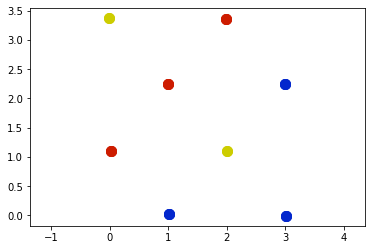

In [150]:
for ii in clu_ident:
    pos = clu_ident == ii
    plt.scatter(xx[pos],
                yy[pos],
                c = cmap[ii],
                s = 100)

plt.axis("equal")